# TP I : Support Vector Machines

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations d'algorithmes de classification autour des SVM. **C'est un *TP à trous* ; il s'agira de compléter ces trous et d'y ajouter les tests qui vous sembleront utiles.**

Voici un aperçu des points abordés lors de ce TP.

- partie I
    - Importation et visualisation des données
- partie II
    - SVM Linéaire
- partie III
    - SVM non-Linéaire
    
Dans l'ensemble du déroulé du TP vous ferez bien attention à valider par un jeu de tests la validité des programmes écrits. Vous regarderez l'influence des paramètres sur la convergence. Vous comparerez les intérêts des diférentes méthodes les unes par rapport aux autres.

**Votre démarche et vos conclusions seront présentées sous forme d'un rapport (de 5 à 10 pages) où vous pourrez choisir d'avoir une approche plus sur les résultats mathématiques ou sur les résultats numériques. Le notebook Jupiter avec l'ensemble de vos travaux sera aussi remis.**


## Attendus de rendu

Votre rendu sera jugé à l'aune de

- votre capacité à produire des algorithmes valides, répondant à la question posée
- l'étude effectuée concernant la sensibilité de vos algorithmes aux hyperparamètres / conditions initiales
- l'analyse comparative proposée quant aux différentes implémentations suggérées 
- les stress-tests auxquels vous aurez confrontés vos implémentations. 

On portera une attention particulière à la *généricité* de votre réponse ; tout comme cela vous est suggéré par la suite on attendra de vous d'appuyer vos affirmations par suffisamment de tests et une appréciation pour les limites de votre analyse.

Ce TP est à rendre par **groupes de 3** et exceptionnellement **2**.

# Au travail!

In [1]:
import warnings
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [3]:
!pip install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     -------------------------------------- 250.0/250.0 kB 7.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## I- Importation et préparation des données

Nous allons ici introduire quelques datasets qui permettront de tester les méthodes.


### 1. Importation

Importer **data1** le dataset proposé pour faire les premiers tests



In [4]:
df1 = pd.read_excel('data1.xlsx')

In [5]:
df1.head(10)

,échantillon,caractère1,caractère2,classe
0,1,0.5,2.5,1
1,2,0.8,2.8,1
2,3,1.5,3.5,1
3,4,0.2,0.2,-1
4,5,0.6,0.6,-1
5,6,1.7,1.7,-1
6,7,1.0,4.0,1
7,8,0.6,3.0,1
8,9,1.5,0.5,-1


Identifier la colonne qui servira à classifier et qui ne prend donc que 2 valeurs.

### 2. visualisation

Visualiser les deux premières colonnes qui ont des valeurs numériques, sous forme d'un nuage de points (avec un marqueur différent en fonction de la valeur servant à classifier).

In [6]:
def visu(df_):
    value=(df_['classe']>0)
    df_['color']= np.where( value==True , "red", "blue")

    plt.scatter(df_.iloc[:,1],df_.iloc[:,2],color= df_.color)
    plt.show()


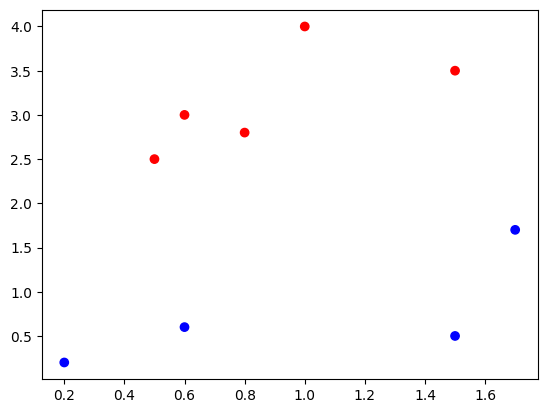

In [7]:
visu(df1)

In [8]:
df1.head(10)


,échantillon,caractère1,caractère2,classe,color
0,1,0.5,2.5,1,red
1,2,0.8,2.8,1,red
2,3,1.5,3.5,1,red
3,4,0.2,0.2,-1,blue
4,5,0.6,0.6,-1,blue
5,6,1.7,1.7,-1,blue
6,7,1.0,4.0,1,red
7,8,0.6,3.0,1,red
8,9,1.5,0.5,-1,blue


Regarder aussi les fichiers **data2**, **data3** et **data4**

In [9]:
df2 = pd.read_excel('data2.xlsx')

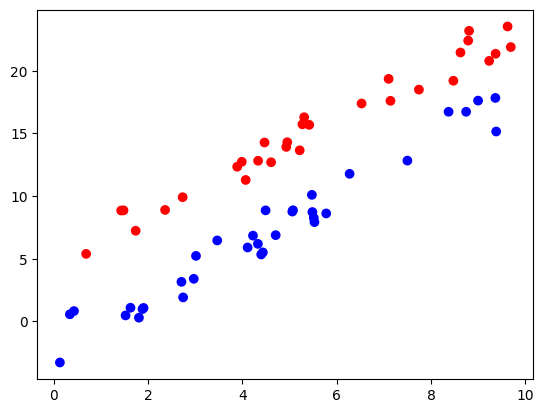

In [10]:
visu(df2)

In [16]:
df2.head(5)

,échantillon,caractère1,caractère2,classe,color
0,1,3.987074,12.732375,1,red
1,2,7.140397,17.598245,1,red
2,3,4.069666,11.285396,1,red
3,4,8.624961,21.452636,1,red
4,5,9.691999,21.887114,1,red


In [11]:
df3 = pd.read_excel('data3.xlsx')

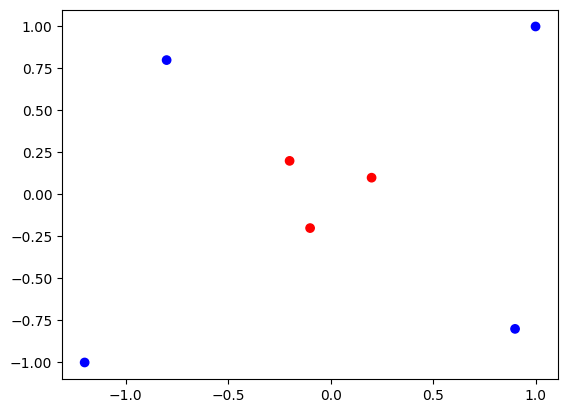

In [12]:
visu(df3)

In [17]:
df3.head(5)

,échantillon,caractère1,caractère2,classe,color
0,1,-0.2,0.2,1,red
1,2,0.2,0.1,1,red
2,3,-0.1,-0.2,1,red
3,4,1.0,1.0,-1,blue
4,5,-0.8,0.8,-1,blue


In [13]:
df4 = pd.read_excel('data4.xlsx')

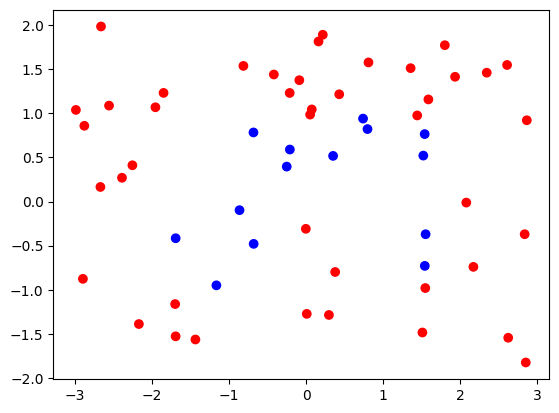

In [14]:
visu(df4)

In [18]:
df4.head(5)

,échantillon,caractère1,caractère2,classe,color
0,1,-2.169574,-1.389207,1,red
1,2,-1.692503,-0.416437,-1,blue
2,3,-0.088212,1.375374,1,red
3,4,-1.699147,-1.162686,1,red
4,5,-1.164085,-0.950356,-1,blue


## II- SVM - le cas linéaire

Nous allons ici rappeler les points essentiels qui ont été vus en cours et qui serviront à l'implémentation de l'algorithme.

On a une population de $n$ individus.

On dispose, pour chaque individu $i$, de ses caractéristiques $X_i \in \mathbb{R}^p$ et d'un indicateur de décision $y_i \in \{ -1 ; +1\}$.

Le problème de SVM linéaire revient à chercher $(\omega,b)\in \mathbb{R}^p \times \mathbb{R}$ tel que $(\omega,b)$ soit solution du problème d'optimisation sous contraintes:

$\displaystyle (HM):\quad \min_{\begin{matrix} \omega,b \, t.q. \\ y_i\left( \omega . X_i  - b\right) \ge 1 \\ 1\le i \le N \end{matrix}}\frac{1}{2}||\omega||^2$.

Géométriquement cela revient à séparer les points $X_i$ par des hyperplans:
- $\omega . X  - b = 0$ qui sera l'hyperplan de décision.
- Les deux hyperplans $\omega . X  - b = +1$ et $\omega . X  - b = -1 $ étant espacés au maximum tout en gardant les points tels que $y_i=+1$ et $y_i=-1$ à l'extérieur de la bande qu'ils délimitent.

Le problème ci-dessus est le **problème primal**. Nous avons vu en cours sur l'optimisation sous contrainte (et après introduction du Lagrangien), que ce problème est équivalent au **problème dual**

$\displaystyle (HM*):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2}\sum_{1\le i,j \le N} \alpha_i \alpha_j y_i y_j X_i^TX_j-\sum_{1\le i \le N}\alpha_i$.

où les inconnues sont les $(\alpha_1,\cdots, \alpha_n)$ qui sont les multiplicateurs de Lagrange.

Si on note $G=\big(y_i y_j X_i ^T X_j \big)_{\begin{matrix} 1 \le i \le N \\ j \le i \le N \end{matrix}}$, la matrice de Gram, le problème s'écrit:

$\displaystyle (HM*):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2} \alpha^TG\alpha-\sum_{1\le i \le N}\alpha_i$.

Ce problème peut se résoudre en utilisant par exemple un algorithme de gradient projeté car $\displaystyle \{ \alpha \in \mathbb{R}^N \, t.q. \, \alpha_i \ge 0 \, , \, 1 \le i \le N  \, et \, \sum_{i=0}^n \alpha_i y_i =0 \}$ est un convexe sur lequel il est "relativement" facile de projeter un vecteur de $ \mathbb{R}^N$


Une fois les $\alpha=(\alpha_1,\cdots,\alpha_N)$ calculés, on se souvient que comme on est situé au niveau du point selle du Lagrangien, on a aussi $\displaystyle \omega = \sum_{1 \le i \le N}\alpha_i yi X_i$. Cela nous permet de calculer $\omega$

On remarque que beaucoup de $\alpha_i$ sont nuls, ce qui signifient que ces contraintes ne sont pas qualifiées (au sens de la théorie du Lagrangien). Les $i$ qui correspondent à des $\alpha_i \neq 0$ correspondent aux Support Vectors (c'est à dire aux $X_i$ situés sur les hyperplans définissant la marge) et donc $F(X_i) = \pm 1$ pour ces vecteurs.

On pourra se servir de la remarque ci-dessus pour calculer $b$.

On aura donc ainsi entièrement défini notre hyperplan qui constitue la "decision boundary".

**On peut aussi voir les choses un peu différemment (et cela sera utile plus tard pour traiter le cas non linéaire):**
- En introduisant la fonction $\displaystyle F(X) = \sum_{1 \le i \le N}\alpha_i yi X_i^T X - b$ qui va de $\mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$.

- On a $C_0 F$ qui est l'hyperplan de séparation entre les points $+1$ et les points $-1$. et $C_{-1} F$ et $C_{+1} F$ sont les deux hyperplans de marge (on rappelle que $C_k F$ est la courbe de niveau de valeur $k$ pour la fonction $F$, c'est à dire $\{ X \in \mathbb{R}^m \, t.q. F(X)=k \}$ ).


### 1. Le gradient projeté

Créer un algorithme de descente de gradient (par exemple récupéré dans le TP de descente de gradient de OCVX1).
Le modifier pour qu'à chaque pas de descente, le gradient soit projeté sur $\{ \alpha \in \mathbb{R}^N \, t.q. \, \alpha_i \ge 0 \, , \, 1 \le i \le N  \, et \, \sum_{i=0}^n \alpha_i y_i =0 \}$.


**C'est la fonction ci-dessous qu'il faut modifier en important de dont vous avez besoin du TP OCVX1**

In [ ]:
def desc_grad_opti_proj (f,y,p0,eps=1E-5):
    x=[np.array(p0)]

    while True:

        descente = - gradient(f,x[-1])
        mu = 
        
        x.append(x[-1] + mu * descente)
#     modifier la ligne ci-dessus pour projeter
#     sur le convexe R+^n et le plan somme(alpha_i yi)=0 
        
        # tests de convergence ou de divergence
        
    return np.array(x)


### 2. Résolution du problème dual

Créer une fonction prepa_donnees qui prépare les données dont on a besoin (df,X,y,Gram) pour la résolution du problème dual à partir d'un fichier "nom_data".

In [ ]:
def prepa_donnees(nom_data):
    """
    Description: 
    Parameters:
    nom_data: nom du fichier dans lequel aller chercher les données
    
    Output
    df: dataframe panda contenant les données
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    Gram: la matrice de Gram du problème de taille (nb_individus x nb_individus)
    """    

    
    return df,X,y,Gram
    

Définir une fonction qui définit la fonctionnelle à minimiser $\displaystyle J(\alpha)=  \frac{1}{2} \alpha^TG\alpha-\sum_{1\le i \le N}\alpha_i$

In [ ]:
    def J(alpha):


Avec les modules que vous venez de créer, vous pouvez maintenant calculer les valeurs de $\alpha_1,\cdots,\alpha_N$ comme étant la solution du problème $(HM*)$. Commencez avec le fichier **data1**




Calculer maintenant $\omega$ et $b$. Ici on aura $\omega = (a_1,a_2)$ et notre hyperplan se limitera à la droite $a_1 x + a_2 y +b=0$.


Visualisez les résultats en reprenant la visualisation du nuage de nos points réalisé au $\bf{I-2}$ et en rajoutant les hyperplans caractéristiques qu'on vient de calculer.

A ce stade ... si tout se passe bien vous avez dû trouver, en utilisant les données de **data1**, que la frontière de décision est la droite $y=x+1$ et que les deux frontières pour la marge maximum sont les droites  $y=x$ et $y=x+2$.

In [ ]:
def visu_front(df,a1_,a2_,b_):
    # tracer notre nuage de point distinguant les deux types de classificateurs +1 et -1
    # ainsi que les droites a_1 x + a_x = 0, -1, +1
    
    plt.show()


In [ ]:
visu_front(df,a1,a2,b)

### 3. Cas plus large et cas non séparable linéairement

Tester ce que vous venez de faire sur **data2** et **data3**.
Que remarquez vous?

## II- SVM - le cas non linéaire - "the Kernel Trick"

Comme nous avons vu en TD, on peut chercher à séparer nos points avec des fonctions plus compliquées que des hyperplans en se projetant dans un espace de dimension plus grande.

Ce qui permet de faire cela sans que cela représente un coût trop élevé est la remarque que cette projection dans un espace de dimension plus grande n'a pas besoin d'être explicitée. On n'aura besoin que d'une expression des produits scalaires des projetés.

En pratique on se donne donc un noyau $K: \mathbb{R}^N \times \mathbb{R}^N \to \mathbb{R}$ de la forme $K(q,q')$ qui possède la propriété d'être symétrique et défini positif.

On est ramené au même propblème dual que précédemment en remplaçant les produits scalaires par ce noyau.

Le problème (dual) à résoudre est donc:

$\displaystyle (HM**):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2}\sum_{1\le i,j \le N} \alpha_i \alpha_j y_i y_j K(X_i,X_j)-\sum_{1\le i \le N}\alpha_i$.

où les inconnues sont les $(\alpha_1,\cdots, \alpha_n)$ qui sont les multiplicateurs de Lagrange.

Si on note $G=\big(y_i y_j K(X_i,X_j) \big)_{\begin{matrix} 1 \le i \le N \\ j \le i \le N \end{matrix}}$, la matrice de Gram, le problème s'écrit:

$\displaystyle (HM**):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2} \alpha^TG\alpha-\sum_{1\le i \le N}\alpha_i$.

Une fois les $\alpha=(\alpha_1,\cdots,\alpha_N)$ calculés, on introduit la fonction $\displaystyle F(X) = \sum_{1 \le i \le N}\alpha_i yi K(X_i, X)$ qui va de $\mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$.

On a $C_0 F$ qui est l'hyperplan de séparation entre les points $+1$ et les points $-1$. et $C_{-1} F$ et $C_{+1} F$ sont les deux hyperplans de marge (on rappelle que $C_k F$ est la courbe de niveau de valeur $k$ pour la fonction $F$, c'est à dire $\{ X \in \mathbb{R}^m \, t.q. F(X)=k \}$ ).


### 1. Introduire la méthode du Kernel et tester sur un cas simple

Définir le noyau polynomial $K(q,q')=(1+q.q')^d$. Prendre d=2 pour commencer.

In [ ]:
def K(q1,q2,d=6):


Modifier la fonction prepa_donnees qui prépare les données dont on a besoin (df,X,y,Gram) pour la résolution du problème dual à partir d'un fichier "nom_data".

In [ ]:
def prepa_donnees_ker(nom_data):
    """
    Description: 
    Parameters:
    nom_data: nom du fichier dans lequel aller chercher les données
    
    Output
    df: dataframe panda contenant les données
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les 
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    Gram: la matrice Gram du problème de taille (nb_individus x nb_individus)
    """    

    
    return df,X,y,Gram
    

Avec les modules que vous venez de créer, vous pouvez maintenant calculer les valeurs de $\alpha_1,\cdots,\alpha_N$ comme étant la solution du problème $(HM**)$ avec le fichier **data3**.




Introduire la nouvelle fonction "séparatrice" $\displaystyle F(X) = \sum_{1 \le i \le N}\alpha_i yi K(X_i, X) - b$ qui va de $\mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$.

$b$ sera calculé en reprenant la remarque que $F(X_i)=\pm 1$ quand $X_i$ correspond à un Support Vector et donc que $\alpha_i \ne 0$.

In [ ]:
def F_separ(Z):


Visualisez les résultats prenant le fichier **data3** avec le nuage de points et en rajoutant les courbes de niveau $-1$, $0$ et $+1$ de la fonction F_separ que nous venons d'introduire.

In [ ]:
def visu_front_ker(df,X):
    # tracer notre nuage de point distinguant les deux types de classificateurs +1 et -1
    # ainsi que les courbes de niveau de F_separ = 0, -1, +1


    
    plt.show()


In [ ]:
visu_front_ker(df,X)

### 2. Cas plus large et cas non séparable linéairement

Tester ce que vous venez de faire sur **data4**.
Que remarquez vous? Comment améliorer la situation? Essayez en particulier d'autres noyaux comme le noyau gaussien:

$$k(x_i, x_j) = \exp\left(- \frac{||x_i- x_j||^2}{2\;l\;^2} \right)$$